In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import savgol_filter
import fly_analysis as fa
from tqdm import tqdm
from datetime import datetime
from dataclasses import dataclass
import os
import scipy
import pynumdiff

date_time = datetime.now().strftime("%Y%m%d_%H%M%S")
print(date_time)

os.makedirs(f"Figures/dnp03_paper/{date_time}", exist_ok=True)

20241108_112758


In [2]:
@dataclass
class SaccadeConfig:
    """Configuration parameters for saccade detection and analysis"""

    n_before: int = 100  # frames before saccade
    n_after: int = 100  # frames after saccade
    stim_window: int = 50  # window to look for stimulus-elicited saccades
    min_group_length: int = 200
    delay: int = 15  # delay for no-saccade cases
    ang_vel_threshold: float = np.deg2rad(300)  # mianimum angular velocity for saccade
    lin_vel_threshold: float = 0.01  # minimum linear velocity for saccade
    peak_distance: int = 10  # minimum distance between peaks

# Analysis functions

In [ ]:
def sg_smooth(df):
    """
    Applies Savitzky-Golay filter to smooth specified columns in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the columns to be smoothed.

    Returns:
    pandas.DataFrame: The DataFrame with smoothed columns.

    The function applies the Savitzky-Golay filter with a window length of 21 and a polynomial order of 3
    to the columns 'x', 'y', 'z', 'xvel', 'yvel', and 'zvel' in the input DataFrame.
    """
    columns = ["x", "y", "z", "xvel", "yvel", "zvel"]
    df[columns] = df[columns].apply(lambda x: savgol_filter(x, 21, 3))
    return df


def plot_mean_and_std(data, ax, label=None):
    data = np.abs(data)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)

    ax.plot(mean, label=label)
    ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2)
    return ax


def polar_histogram(
    ax,
    angles,
    bins=16,
    density=None,
    offset=0,
    lab_unit="degrees",
    start_zero=False,
    **param_dict,
):
    """
    Plot polar histogram of angles on ax. ax must have been created using
    subplot_kw=dict(projection='polar'). Angles are expected in radians.
    """
    # Wrap angles to [-pi, pi)
    angles = (angles + np.pi) % (2 * np.pi) - np.pi

    # Set bins symetrically around zero
    if start_zero:
        # To have a bin edge at zero use an even number of bins
        if bins % 2:
            bins += 1
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    count, bin = np.histogram(angles, bins=bins)

    # Compute width of each bin
    widths = np.diff(bin)

    # By default plot density (frequency potentially misleading)
    if density is None or density is True:
        # Area to assign each bin
        area = count / angles.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    else:
        radius = count

    # Plot data on ax
    ax.bar(
        bin[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="C0",
        fill=False,
        linewidth=1,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels, they are mostly obstructive and not informative
    ax.set_yticks([])

    if lab_unit == "radians":
        label = [
            "$0$",
            r"$\pi/4$",
            r"$\pi/2$",
            r"$3\pi/4$",
            r"$\pi$",
            r"$5\pi/4$",
            r"$3\pi/2$",
            r"$7\pi/4$",
        ]
        ax.set_xticklabels(label)


def plot_histogram(arr, ax=None, label=None):
    """
    Plots a histogram of the given array with a density estimate.

    Parameters:
    arr (array-like): The input data array to plot.
    ax (matplotlib.axes.Axes, optional): The axes on which to plot the histogram.
                                         If None, a new figure and axes are created.
    label (str, optional): The label for the histogram.

    Returns:
    matplotlib.axes.Axes: The axes with the plotted histogram.
    """
    if ax is None:
        _, ax = plt.subplots()

    sns.histplot(
        arr,
        ax=ax,
        bins=36,
        binrange=(-np.pi, np.pi),
        stat="density",
        kde=True,
    )
    return ax


def calculate_inverted_signed_angle(v1, v2):
    # Calculate the signed angle between two vectors
    angle = np.arctan2(np.cross(v1, v2), np.dot(v1, v2))

    # Invert the angle
    if angle >= 0:
        inverted_angle = np.pi - angle
    else:
        inverted_angle = -np.pi - angle

    return inverted_angle  # This will be in radians, in the range [-π, π]


def get_heading_difference_for_trajectory(xyz, midpoint=65, n_around=10):
    if np.shape(xyz)[1] == 3:
        xyz = xyz[:, :2]

    vector_before = xyz[midpoint - n_around] - xyz[midpoint]
    vector_after = xyz[midpoint + n_around] - xyz[midpoint]

    return calculate_inverted_signed_angle(vector_before, vector_after)


def get_all_saccade_data(df, stim, save_plots=False, plot_dir=None, **kwargs):
    config = SaccadeConfig(**kwargs)

    # initialize results dictionary
    results = {
        "angular_velocity": [],
        "linear_velocity": [],
        "heading_diff": [],
        "group": [],
    }

    # iterate over each stimulus
    for _, row in tqdm(stim.iterrows(), total=len(stim)):
        # get group data
        group_mask = (df["obj_id"] == row["obj_id"]) & (df["exp_num"] == row["exp_num"])
        grp = df[group_mask].copy()

        # skip groups with insufficient data
        if len(grp) < config.min_group_length:
            continue

        # get stimulus index
        stim_idx = np.where(grp["frame"] == row["frame"])[0]
        if len(stim_idx) == 0:  # skip if stimulus not found
            stim_idx = None
        else:  # take first index if multiple found
            stim_idx = stim_idx[0]

        # Smooth data
        grp = sg_smooth(grp)

        # Calculate angular and linear velocity
        xvel, yvel = grp["xvel"].to_numpy(), grp["yvel"].to_numpy()
        x, y, z = grp["x"].to_numpy(), grp["y"].to_numpy(), grp["z"].to_numpy()

        # Calculate angular and linear velocity
        theta = np.arctan2(yvel, xvel)
        theta_unwrap = np.unwrap(theta)
        _, angular_velocity = pynumdiff.smooth_finite_difference.butterdiff(
            theta_unwrap, dt=0.01, params=[1, 0.1]
        )
        linear_velocity = np.sqrt(xvel**2 + yvel**2)

        saccades, _ = scipy.signal.find_peaks(
            np.abs(angular_velocity),
            height=config.ang_vel_threshold,
            distance=config.peak_distance,
        )

        for sac_idx in saccades:
            # skip saccades at the beginning and end of the experiment
            if sac_idx - config.n_before < 0 or sac_idx + config.n_after >= len(
                angular_velocity
            ):
                continue

            # skip saccades around stimulus
            if stim_idx is not None:
                if stim_idx <= sac_idx <= stim_idx + config.stim_window:
                    continue

            # check if saccade is in center
            if (
                (0.05 <= z[sac_idx] <= 0.25)
                and (-0.2 <= x[sac_idx] <= 0.2)
                and (-0.2 <= y[sac_idx] <= 0.2)
            ):
                results["angular_velocity"].append(
                    angular_velocity[
                        sac_idx - config.n_before : sac_idx + config.n_after
                    ]
                )
                results["linear_velocity"].append(
                    linear_velocity[
                        sac_idx - config.n_before : sac_idx + config.n_after
                    ]
                )
                results["heading_diff"].append(
                    get_heading_difference_for_trajectory(
                        grp[["x", "y"]].values, sac_idx
                    )
                )
                results["group"].append("spontaneous")

        # get stimulus-elicited saccades
        if stim_idx is not None:
            response_idx = stim_idx + config.delay
            if (
                response_idx - config.n_before < 0
                or response_idx + config.n_after >= len(angular_velocity)
            ):
                continue

            angvel = angular_velocity[
                response_idx - config.n_before : response_idx + config.n_after
            ]
            linvel = linear_velocity[
                response_idx - config.n_before : response_idx + config.n_after
            ]
            hd = get_heading_difference_for_trajectory(
                grp[["x", "y"]].values, response_idx
            )

            results["angular_velocity"].append(angvel)
            results["linear_velocity"].append(linvel)
            results["heading_diff"].append(hd)
            results["group"].append("stimulus")

    # convert lists to numpy arrays
    for key in results:
        results[key] = np.array(results[key])

    return results


def group_index(results, group):
    return np.array([i for i, x in enumerate(results["group"]) if x == group]).astype(
        int
    )


def opto_summary_plot(data: dict, group: str):
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

    for response in np.unique(data["group"]):
        idx = group_index(data, response)
        angvel = np.rad2deg(data["angular_velocity"][idx])
        linvel = data["linear_velocity"][idx]
        heading_diff = data["heading_diff"][idx]

        plot_mean_and_std(angvel, axs[0], label=f"{response} n={len(angvel)}")
        plot_mean_and_std(linvel, axs[1])
        plot_histogram(heading_diff, axs[2])

    fig.legend()
    plt.tight_layout()
    plt.show()

In [4]:
root_folder = "/home/buchsbaum/mnt/md0/Experiments/"
checkpoint_path = "/home/buchsbaum/src/fly_analysis/notebooks/checkpoints/"
data_path = "/home/buchsbaum/src/fly_analysis/notebooks/data/"

In [5]:
from typing import List, Dict, Optional, Literal
from pathlib import Path
import h5py

StorageFormat = Literal["parquet", "hdf5", "feather"]


def process_braidz_files(
    files: List[str],
    root_folder: str,
    output_path: str,
    group_id: str,
    storage_format: StorageFormat = "parquet",
    compression: Optional[str] = "snappy",
) -> Dict[str, pd.DataFrame]:
    """
    Process braidz files and save results in efficient format for large datasets.

    Args:
        files: List of braidz filenames to process
        root_folder: Root directory containing the braidz files
        output_path: Directory where processed files should be saved
        group_id: Group identifier for organizing output files
        storage_format: Format to save data in ('parquet', 'hdf5', or 'feather')
        compression: Compression method (format-specific, default 'snappy' for parquet)

    Returns:
        Dictionary mapping keys to processed DataFrames

    Storage Format Details:
        - parquet: Best for column-oriented data, good compression, splittable
        - hdf5: Good for hierarchical data, fast random access
        - feather: Fastest read/write times, but larger file size
    """
    # Create output directory if it doesn't exist
    group_output_dir = Path(output_path) / group_id
    group_output_dir.mkdir(parents=True, exist_ok=True)

    def get_file_extension() -> str:
        return {"parquet": ".parquet", "hdf5": ".h5", "feather": ".feather"}[
            storage_format
        ]

    def save_dataframe(df: pd.DataFrame, key: str, output_file: Path) -> None:
        if storage_format == "parquet":
            # Parquet with snappy compression (good balance of speed/size)
            df.to_parquet(
                output_file, compression=compression, index=False, engine="pyarrow"
            )
        elif storage_format == "hdf5":
            # HDF5 with table format for better performance with large datasets
            df.to_hdf(
                output_file,
                key=key,
                mode="a",
                format="table",
                complevel=5 if compression else 0,
                complib="blosc:lz4",
            )
        elif storage_format == "feather":
            # Feather format with optional LZ4 compression
            df.to_feather(output_file, compression=compression)

    def read_dataframe(file_path: Path, key: str) -> pd.DataFrame:
        if storage_format == "parquet":
            return pd.read_parquet(file_path)
        elif storage_format == "hdf5":
            return pd.read_hdf(file_path, key=key)
        elif storage_format == "feather":
            return pd.read_feather(file_path)

    # Check if all files already exist
    def get_existing_data() -> Optional[Dict[str, pd.DataFrame]]:
        try:
            extension = get_file_extension()
            existing_files = list(group_output_dir.glob(f"*{extension}"))

            if not existing_files:
                return None

            if storage_format == "hdf5":
                # For HDF5, all data is in one file
                h5_file = group_output_dir / f"data{extension}"
                if not h5_file.exists():
                    return None
                with h5py.File(h5_file, "r") as f:
                    return {key: pd.read_hdf(h5_file, key=key) for key in f.keys()}
            else:
                # For parquet and feather, each DataFrame is in a separate file
                return {
                    file.stem: read_dataframe(file, file.stem)
                    for file in existing_files
                }

        except Exception as e:
            print(f"Error reading existing files: {e}")
            return None

    # Try to load existing data first
    existing_data = get_existing_data()
    if existing_data is not None:
        print(f"Loaded existing {storage_format} files for {group_id}")
        return existing_data

    # Process braidz files if data doesn't exist
    try:
        print(f"Processing {group_id} files: {', '.join(files)}")
        processed_data = fa.braidz.read_multiple_braidz(files, root_folder)

        # Save processed data
        if storage_format == "hdf5":
            # Save all DataFrames to a single HDF5 file
            output_file = group_output_dir / f"data{get_file_extension()}"
            for key, df in processed_data.items():
                if not isinstance(df, pd.DataFrame):
                    continue
                save_dataframe(df, key, output_file)
                print(f"Saved {key} to {output_file}")
        else:
            # Save each DataFrame to a separate file
            for key, df in processed_data.items():
                if not isinstance(df, pd.DataFrame):
                    continue
                output_file = group_output_dir / f"{key}{get_file_extension()}"
                save_dataframe(df, key, output_file)
                print(f"Saved {key} to {output_file}")

        return processed_data

    except Exception as e:
        print(f"Error processing braidz files: {e}")
        raise

In [ ]:
from typing import Optional, Tuple, Dict, Union
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans, KShape


def cluster_timeseries(
    X: np.ndarray,
    n_clusters: int = 2,
    time_window: Optional[Tuple[int, int]] = None,
    method: str = "kmeans",
    preprocess: bool = True,
    resample_size: Optional[int] = None,
    metric: str = "dtw",
    random_state: int = 42,
    verbose: bool = False,
) -> Tuple[np.ndarray, Dict]:
    """
    Cluster time series data with optional preprocessing and time window selection.

    Args:
        X: Input time series data of shape (n_samples, n_timesteps)
        n_clusters: Number of clusters (default: 2)
        time_window: Optional tuple of (start, end) indices for time window selection
        method: Clustering method ('kmeans' or 'kshape', default: 'kmeans')
        preprocess: Whether to apply mean-variance scaling (default: True)
        resample_size: Optional size for resampling the time series
        metric: Distance metric for kmeans (default: 'dtw', ignored for kshape)
        random_state: Random state for reproducibility (default: 42)
        verbose: Whether to print progress information (default: False)

    Returns:
        Tuple of (cluster labels, metadata dictionary)
    """
    try:
        # Input validation
        if not isinstance(X, np.ndarray) or X.ndim != 2:
            raise ValueError("X must be a 2D numpy array")

        # Extract time window if specified
        if time_window is not None:
            if len(time_window) != 2 or time_window[0] >= time_window[1]:
                raise ValueError(
                    "time_window must be a tuple of (start, end) with start < end"
                )
            X = X[:, time_window[0] : time_window[1]]

        # Preprocess data
        if preprocess:
            X = TimeSeriesScalerMeanVariance().fit_transform(X)

        # Resample if specified
        if resample_size is not None:
            if resample_size <= 0:
                raise ValueError("resample_size must be positive")
            X = TimeSeriesResampler(sz=resample_size).fit_transform(X)

        # Initialize clusterer
        if method.lower() == "kmeans":
            clusterer = TimeSeriesKMeans(
                n_clusters=n_clusters,
                metric=metric,
                random_state=random_state,
                verbose=verbose,
            )
        elif method.lower() == "kshape":
            clusterer = KShape(
                n_clusters=n_clusters, random_state=random_state, verbose=verbose
            )
        else:
            raise ValueError("method must be 'kmeans' or 'kshape'")

        # Perform clustering
        labels = clusterer.fit_predict(X)

        # Prepare metadata
        metadata = {
            "n_samples": len(X),
            "n_timesteps": X.shape[1],
            "cluster_sizes": np.bincount(labels).tolist(),
            "cluster_centers": clusterer.cluster_centers_
            if hasattr(clusterer, "cluster_centers_")
            else None,
            "preprocessing": "mean_var" if preprocess else "none",
            "method": method,
            "time_window": time_window,
        }

        return labels, metadata

    except Exception as e:
        logger.error(f"Error in clustering: {str(e)}")
        raise


In [ ]:
def detect_response_peak(
    angular_velocity, start_idx, search_window=50, height=np.deg2rad(300), distance=50
):
    """
    Detect if there's a saccade response within a search window after stimulus.

    Parameters:
    -----------
    angular_velocity : array-like
        Angular velocity time series
    start_idx : int
        Starting index (stimulus onset)
    search_window : int
        Number of frames to search after stimulus
    height : float
        Minimum peak height to be considered a response

    Returns:
    --------
    int or None
        Index of response peak if found, None otherwise
    """
    from scipy.signal import find_peaks

    # Define search region
    end_idx = min(start_idx + search_window, len(angular_velocity))
    search_region = angular_velocity[start_idx:end_idx]

    # Look for peaks in both directions
    peaks_pos, _ = find_peaks(search_region, height=height, distance=distance)
    peaks_neg, _ = find_peaks(-search_region, height=height, distance=distance)

    all_peaks = np.concatenate([peaks_pos, peaks_neg])
    response_direction = ["pos"] * len(peaks_pos) + ["neg"] * len(peaks_neg)

    sort_idx = np.argsort(all_peaks)
    all_peaks = all_peaks[sort_idx]
    response_direction = np.array(response_direction)[sort_idx]

    if len(all_peaks) > 0:
        # Return the first peak found (relative to stimulus onset)
        return start_idx + all_peaks[0], response_direction[0]
    return None, None


def compute_heading_change(
    theta_unwrap,
    center_idx,
    k_frames=10,
    method="mean",
    buffer_frames=None,
    x=None,
    y=None,
):
    """
    Compute the change in heading around a specified index using different methods.

    Parameters:
    -----------
    theta_unwrap : array-like
        Unwrapped heading angles in radians
    center_idx : int
        Index around which to compute change
    k_frames : int
        Number of frames before/after to compute change or distance from peak for vector calculation
    method : str
        'mean': Use mean heading with optional buffer
        'vector': Use vectors at k distance from peak
    buffer_frames : int or None
        If using 'mean' method, number of frames to skip around the peak
    x, y : array-like or None
        Required for 'vector' method, position coordinates

    Returns:
    --------
    float
        Change in heading in radians, between -π and π
    """
    if method == "mean":
        # Ensure bounds including buffer if specified
        buffer = buffer_frames if buffer_frames is not None else 0
        total_frames_needed = k_frames + buffer

        if (
            center_idx - total_frames_needed < 0
            or center_idx + total_frames_needed >= len(theta_unwrap)
        ):
            return None

        # Compute mean heading before and after, respecting buffer
        pre_heading = np.mean(
            theta_unwrap[center_idx - total_frames_needed : center_idx - buffer]
        )
        post_heading = np.mean(
            theta_unwrap[center_idx + buffer : center_idx + total_frames_needed]
        )

        # Compute change and wrap to [-π, π]
        heading_change = np.arctan2(
            np.sin(post_heading - pre_heading), np.cos(post_heading - pre_heading)
        )

    elif method == "vector":
        if x is None or y is None:
            raise ValueError("x and y coordinates are required for vector method")

        # Ensure bounds
        if center_idx - k_frames < 0 or center_idx + k_frames >= len(x):
            return None

        # Get points at distance k from peak
        pre_x = x[center_idx - k_frames]
        pre_y = y[center_idx - k_frames]
        post_x = x[center_idx + k_frames]
        post_y = y[center_idx + k_frames]

        # Calculate vectors
        pre_vector = np.array([x[center_idx] - pre_x, y[center_idx] - pre_y])
        post_vector = np.array([post_x - x[center_idx], post_y - y[center_idx]])

        # Normalize vectors
        pre_vector = pre_vector / np.linalg.norm(pre_vector)
        post_vector = post_vector / np.linalg.norm(post_vector)

        # Calculate angle between vectors
        dot_product = np.clip(np.dot(pre_vector, post_vector), -1.0, 1.0)
        heading_change = np.arccos(dot_product)

        # Determine sign of angle (positive for CCW, negative for CW)
        cross_product = np.cross(pre_vector, post_vector)
        heading_change *= np.sign(cross_product)

    else:
        raise ValueError("Method must be either 'mean' or 'vector'")

    return heading_change


def process_saccade(
    sac_idx, angular_velocity, linear_velocity, x, y, z, stim_idx, theta_unwrap
):
    """
    Process a single saccade, including heading change calculation.
    """
    WINDOW_SIZE = 100
    ARENA_BOUNDS = {"z": (0.05, 0.25), "x": (-0.2, 0.2), "y": (-0.2, 0.2)}

    # Skip if window is out of bounds
    if sac_idx - WINDOW_SIZE < 0 or sac_idx + WINDOW_SIZE >= len(angular_velocity):
        return None

    # Skip if saccade is in stimulus window
    if stim_idx is not None and stim_idx <= sac_idx <= stim_idx + WINDOW_SIZE:
        return None

    # Skip if outside arena bounds
    if not (
        ARENA_BOUNDS["z"][0] <= z[sac_idx] <= ARENA_BOUNDS["z"][1]
        and ARENA_BOUNDS["x"][0] <= x[sac_idx] <= ARENA_BOUNDS["x"][1]
        and ARENA_BOUNDS["y"][0] <= y[sac_idx] <= ARENA_BOUNDS["y"][1]
    ):
        return None

    # Extract velocity windows
    ang_vel_window = angular_velocity[sac_idx - WINDOW_SIZE : sac_idx + WINDOW_SIZE]
    lin_vel_window = linear_velocity[sac_idx - WINDOW_SIZE : sac_idx + WINDOW_SIZE]
    turning_direction = "pos" if angular_velocity[sac_idx] > 0 else "neg"

    # Compute heading change
    heading_change = compute_heading_change(
        theta_unwrap, sac_idx, method="vector", k_frames=25, x=x, y=y
    )

    return (
        "spontaneous",
        ang_vel_window,
        lin_vel_window,
        heading_change,
        turning_direction,
    )


def process_stimulus_window(
    stim_idx, angular_velocity, linear_velocity, x, y, z, theta_unwrap, default_delay=30
):
    """
    Process the stimulus window, including heading change calculation.
    """
    WINDOW_SIZE = 100
    ARENA_BOUNDS = {"z": (0.05, 0.25), "x": (-0.2, 0.2), "y": (-0.2, 0.2)}

    # First check if initial window is out of bounds
    if stim_idx - WINDOW_SIZE < 0 or stim_idx + WINDOW_SIZE >= len(angular_velocity):
        return None

    # Check arena bounds at stimulus time
    if not (
        ARENA_BOUNDS["z"][0] <= z[stim_idx] <= ARENA_BOUNDS["z"][1]
        and ARENA_BOUNDS["x"][0] <= x[stim_idx] <= ARENA_BOUNDS["x"][1]
        and ARENA_BOUNDS["y"][0] <= y[stim_idx] <= ARENA_BOUNDS["y"][1]
    ):
        return None

    # Try to detect a response
    response_idx, response_direction = detect_response_peak(
        angular_velocity,
        stim_idx,
        search_window=50,
        height=np.deg2rad(300),
        distance=10,
    )

    if response_idx is not None:
        # Response detected - align to response
        center_idx = response_idx
        group = "stimulus_response"
    else:
        # No response detected - use default delay
        center_idx = stim_idx + default_delay
        group = "stimulus_no_response"
        response_direction = "none"

    # Check if the aligned window is within bounds
    if center_idx - WINDOW_SIZE < 0 or center_idx + WINDOW_SIZE >= len(
        angular_velocity
    ):
        return None

    # Extract velocity windows aligned to either response or default delay
    ang_vel_window = angular_velocity[
        center_idx - WINDOW_SIZE : center_idx + WINDOW_SIZE
    ]
    lin_vel_window = linear_velocity[
        center_idx - WINDOW_SIZE : center_idx + WINDOW_SIZE
    ]

    # Compute heading change
    heading_change = compute_heading_change(
        theta_unwrap, center_idx, method="vector", k_frames=25, x=x, y=y
    )
    return group, ang_vel_window, lin_vel_window, heading_change, response_direction


def detect_saccades_both(angular_velocity, height=np.deg2rad(300), distance=40):
    """Detect saccades in both positive and negative directions."""
    from scipy.signal import find_peaks

    peaks_pos, _ = find_peaks(angular_velocity, height=height, distance=distance)
    peaks_neg, _ = find_peaks(-angular_velocity, height=height, distance=distance)

    peaks_concat = np.concatenate([peaks_pos, peaks_neg])

    # get directions list
    directions = np.array(["pos"] * len(peaks_pos) + ["neg"] * len(peaks_neg))

    # get sorting indices
    sort_idx = np.argsort(peaks_concat)

    # return sorted peaks and directions
    return peaks_concat[sort_idx], np.array(directions)[sort_idx]


def process_all_trajectories(stim, df):
    """
    Process all trajectories and collect data including heading changes.
    """
    angvels = []
    linvels = []
    groups = []
    heading_changes = []
    turning_directions = []
    distance_from_center = []

    for _, row in tqdm(stim.iterrows(), total=len(stim)):
        obj_id = row["obj_id"]
        exp_num = row["exp_num"]
        frame = row["frame"]

        # Get trajectory data
        grp = df[(df["obj_id"] == obj_id) & (df["exp_num"] == exp_num)].copy()

        if len(grp) < 200:
            continue

        stim_idx = np.where(grp["frame"] == frame)[0]
        stim_idx = stim_idx[0] if len(stim_idx) > 0 else None

        grp = sg_smooth(grp)

        # Calculate all velocities and angles
        x, y, z = grp["x"].to_numpy(), grp["y"].to_numpy(), grp["z"].to_numpy()
        xvel, yvel = grp["xvel"].to_numpy(), grp["yvel"].to_numpy()

        theta = np.arctan2(yvel, xvel)
        theta_unwrap = np.unwrap(theta)
        _, angular_velocity = pynumdiff.smooth_finite_difference.butterdiff(
            theta_unwrap, dt=0.01, params=[1, 0.1]
        )
        linear_velocity = np.sqrt(xvel**2 + yvel**2)

        saccades, directions = detect_saccades_both(angular_velocity)

        # Process spontaneous saccades
        for sac_idx in saccades:
            result = process_saccade(
                sac_idx,
                angular_velocity,
                linear_velocity,
                x,
                y,
                z,
                stim_idx,
                theta_unwrap,
            )
            if result is not None:
                (
                    group,
                    ang_vel_window,
                    lin_vel_window,
                    heading_change,
                    turning_direction,
                ) = result
                groups.append(group)
                angvels.append(ang_vel_window)
                linvels.append(lin_vel_window)
                heading_changes.append(heading_change)
                turning_directions.append(turning_direction)
                distance_from_center.append(np.sqrt(x[sac_idx] ** 2 + y[sac_idx] ** 2))

        # Process stimulus window
        if stim_idx is not None:
            result = process_stimulus_window(
                stim_idx, angular_velocity, linear_velocity, x, y, z, theta_unwrap
            )
            if result is not None:
                (
                    group,
                    ang_vel_window,
                    lin_vel_window,
                    heading_change,
                    turning_direction,
                ) = result
                groups.append(group)
                angvels.append(ang_vel_window)
                linvels.append(lin_vel_window)
                heading_changes.append(heading_change)
                turning_directions.append(turning_direction)
                distance_from_center.append(
                    np.sqrt(x[stim_idx] ** 2 + y[stim_idx] ** 2)
                )

    out_dict = {
        "groups": groups,
        "angular_velocities": angvels,
        "linear_velocities": linvels,
        "heading_changes": heading_changes,
        "turning_directions": turning_directions,
        "distance_from_center": distance_from_center,
    }
    return out_dict

In [ ]:
def align_saccade_direction(velocity_windows):
    """
    Align all saccades to be positive by flipping negative peaks.

    Parameters:
    -----------
    velocity_windows : array
        Array of velocity windows (n_saccades x window_length)

    Returns:
    --------
    array
        Aligned velocity windows where all peaks are positive
    """
    center_idx = velocity_windows.shape[1] // 2
    center_values = velocity_windows[:, center_idx]
    flip_mask = center_values < 0
    aligned_windows = velocity_windows.copy()
    aligned_windows[flip_mask] = -aligned_windows[flip_mask]
    return aligned_windows


def plot_three_panel(
    angvels, linvels, heading_changes, groups, window_size=100, combine_stimulus=False
):
    """
    Create a three-panel figure with angular velocity, linear velocity, and heading change distribution.

    Parameters:
    -----------
    angvels : list of arrays
        Angular velocity windows for each event
    linvels : list of arrays
        Linear velocity windows for each event
    heading_changes : list of floats
        Heading changes in radians
    groups : list of str
        Group labels for each event
    window_size : int
        Size of the window on each side (default: 100)
    combine_stimulus : bool
        If True, combines stimulus_response and stimulus_no_response into a single 'stimulus' group
    """
    # Convert lists to arrays
    angvels = align_saccade_direction(np.rad2deg(angvels))
    linvels = np.array(linvels)
    groups = np.array(groups)
    heading_changes_deg = np.rad2deg(np.array(heading_changes))

    # Combine stimulus groups if requested
    if combine_stimulus:
        # Create new groups array with combined stimulus
        new_groups = np.array(["stimulus" if "stimulus" in g else g for g in groups])
        groups = new_groups

        # Update colors dictionary
        colors = {"spontaneous": "tab:blue", "stimulus": "tab:orange"}
    else:
        colors = {
            "spontaneous": "tab:blue",
            "stimulus_response": "tab:orange",
            "stimulus_no_response": "tab:green",
        }

    # Create figure
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])

    # Calculate time axis
    time = np.linspace(-window_size, window_size, window_size * 2) * 0.01

    # First panel: Angular Velocity
    ax1 = fig.add_subplot(gs[0])
    for group in np.unique(groups):
        mask = groups == group
        mean = np.mean(angvels[mask], axis=0)
        std = np.std(angvels[mask], axis=0)
        ax1.fill_between(time, mean - std, mean + std, alpha=0.3, color=colors[group])
        ax1.plot(time, mean, color=colors[group], label=f"{group} n={np.sum(mask)}")

    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Angular Velocity (rad/s)")
    ax1.grid(True, alpha=0.3)

    # Second panel: Linear Velocity
    ax2 = fig.add_subplot(gs[1])
    for group in np.unique(groups):
        mask = groups == group
        mean = np.mean(linvels[mask], axis=0)
        std = np.std(linvels[mask], axis=0)
        ax2.fill_between(time, mean - std, mean + std, alpha=0.3, color=colors[group])
        ax2.plot(time, mean, color=colors[group])

    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Linear Velocity (m/s)")
    ax2.grid(True, alpha=0.3)

    # Third panel: Heading Change Distribution
    ax3 = fig.add_subplot(gs[2])

    # Create DataFrame for seaborn
    df = pd.DataFrame({"Heading Change (deg)": heading_changes_deg, "Group": groups})

    sns.histplot(
        data=df,
        x="Heading Change (deg)",
        hue="Group",
        stat="density",
        common_norm=False,
        alpha=0.5,
        binwidth=10,
        palette=colors,
        legend=False,
        kde=True,
        ax=ax3,
    )

    ax3.set_xlabel("Heading Change (degrees)")
    ax3.set_ylabel("Density")
    ax3.set_xlim(-180, 180)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.figlegend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.1))

    return fig, (ax1, ax2, ax3)


# Example usage:
"""
# Plot with separate stimulus groups
fig, axes = plot_three_panel(angvels, linvels, heading_changes, groups, combine_stimulus=False)

# Plot with combined stimulus groups
fig, axes = plot_three_panel(angvels, linvels, heading_changes, groups, combine_stimulus=True)
"""

'\n# Plot with separate stimulus groups\nfig, axes = plot_three_panel(angvels, linvels, heading_changes, groups, combine_stimulus=False)\n\n# Plot with combined stimulus groups\nfig, axes = plot_three_panel(angvels, linvels, heading_changes, groups, combine_stimulus=True)\n'

In [ ]:
import os


def plot_and_save_all(results, group):
    plt.close("all")

    out_folder = f"Figures/dnp03_paper/20241105/{group}/"
    os.makedirs(out_folder, exist_ok=True)

    for val in [True, False]:
        title = "Combined" if val else "Separate"

        # demeaned absolute value
        fig, axes = plot_three_panel(
            [np.abs(av) - np.mean(np.abs(av)) for av in results["angular_velocities"]],
            results["linear_velocities"],
            results["heading_changes"],
            results["groups"],
            combine_stimulus=val,
        )
        fig.suptitle(f"{group} (demeaned abs, {title})", fontsize=16)
        plt.tight_layout()
        save_path = os.path.join(out_folder, f"{group}_abs_demean_{title}.png")
        plt.savefig(save_path, dpi=150)

        # absolute value
        fig, axes = plot_three_panel(
            np.abs(results["angular_velocities"]),
            results["linear_velocities"],
            results["heading_changes"],
            results["groups"],
            combine_stimulus=val,
        )
        fig.suptitle(f"{group} (abs, {title})", fontsize=16)
        plt.tight_layout()
        save_path = os.path.join(out_folder, f"{group}_abs_{title}.png")
        plt.savefig(save_path, dpi=150)

        # raw flipped
        fig, axes = plot_three_panel(
            results["angular_velocities"],
            results["linear_velocities"],
            results["heading_changes"],
            results["groups"],
            combine_stimulus=val,
        )
        fig.suptitle(f"{group} (flipped traces, {title})", fontsize=16)
        plt.tight_layout()
        save_path = os.path.join(out_folder, f"{group}_flipped_{title}.png")
        plt.savefig(save_path, dpi=150)

## Data Loading

### DNp03

In [10]:
j53xu68_files = ["20230321_162524.braidz", "20230519_130210.braidz"]
j53_data = process_braidz_files(
    j53xu68_files, root_folder, data_path, "dnp03", storage_format="parquet"
)

Loaded existing parquet files for dnp03


In [11]:
j53_results = process_all_trajectories(j53_data["stim"], j53_data["df"])

100%|██████████| 531/531 [01:30<00:00,  5.86it/s]


### AX-Split

In [12]:
# Process g29xu68 files
g29xu68_files = ["20230512_144203.braidz", "20230203_145747.braidz"]
g29_data = process_braidz_files(
    g29xu68_files, root_folder, data_path, "ax-split", storage_format="parquet"
)

Loaded existing parquet files for ax-split


In [13]:
ax_split_results = process_all_trajectories(g29_data["stim"], g29_data["df"])

100%|██████████| 1574/1574 [03:05<00:00,  8.49it/s]


### Empty-Split

In [14]:
# Process emptyxu68 files
emptyxu68_files = [
    "20230915_171628.braidz",
    "20230206_141606.braidz",
]

empty_data = fa.braidz.read_multiple_braidz(emptyxu68_files, root_folder)

Reading /home/buchsbaum/mnt/md0/Experiments/20230915_171628.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20230206_141606.braidz using pyarrow


In [15]:
empty_split_results = process_all_trajectories(empty_data["stim"], empty_data["df"])

100%|██████████| 391/391 [00:07<00:00, 50.46it/s]


## Plotting

In [ ]:
# Option 1: ColorBrewer qualitative palette (colorblind-friendly)
colors_brewer = ["#1b9e77", "#d95f02", "#7570b3", "#666666"]

# Option 2: Scientific paper-inspired palette
colors_scientific = ["#2f5c85", "#ca562c", "#008c62", "#7c6f91"]

# Option 3: Science journal palette (Nature style)
colors_nature = ["#4c72b0", "#dd8452", "#55a868", "#8172b3"]

# Option 4: Paul Tol's colorblind-friendly palette
colors_tol = ["#332288", "#88CCEE", "#44AA99", "#999933"]

cp = colors_nature

### Compare angular velocities

### Turning Direction Barplot

In [ ]:
# create long dataframe with all data
dnp03_stimulus_mask = np.array(
    [x.startswith("stimulus") for x in j53_results["groups"]]
)
dnp03_turning_directions = np.array(j53_results["turning_directions"])[
    dnp03_stimulus_mask
]
dnp03_pos_turn_count = sum(dnp03_turning_directions == "pos")
dnp03_neg_turn_count = sum(dnp03_turning_directions == "neg")
dnp03_none_turn_count = sum(dnp03_turning_directions == "none")

ax_split_stimulus_mask = np.array(
    [x.startswith("stimulus") for x in ax_split_results["groups"]]
)
ax_split_turning_directions = np.array(ax_split_results["turning_directions"])[
    ax_split_stimulus_mask
]
ax_split_pos_turn_count = sum(ax_split_turning_directions == "pos")
ax_split_neg_turn_count = sum(ax_split_turning_directions == "neg")
ax_split_none_turn_count = sum(ax_split_turning_directions == "none")

empty_stimulus_mask = np.array(
    [x.startswith("stimulus") for x in empty_split_results["groups"]]
)
empty_turning_directions = np.array(empty_split_results["turning_directions"])[
    empty_stimulus_mask
]
empty_pos_turn_count = sum(empty_turning_directions == "pos")
empty_neg_turn_count = sum(empty_turning_directions == "neg")
empty_none_turn_count = sum(empty_turning_directions == "none")


# Create initial DataFrame with counts
data = {
    "Group": ["DNp03"] * 3 + ["AX-Split"] * 3 + ["Empty-split"] * 3,
    "Direction": ["Positive", "None", "Negative"] * 3,
    "Count": [
        # DNp03 counts
        dnp03_pos_turn_count,
        dnp03_none_turn_count,
        dnp03_neg_turn_count,
        # AX-Split counts
        ax_split_pos_turn_count,
        ax_split_none_turn_count,
        ax_split_neg_turn_count,
        # Empty-split counts
        empty_pos_turn_count,
        empty_none_turn_count,
        empty_neg_turn_count,
    ],
}

df = pd.DataFrame(data)

# Calculate total counts for each group
group_totals = df.groupby("Group")["Count"].transform("sum")

# Calculate percentages
df["Percentage"] = (df["Count"] / group_totals) * 100

# Create the percentage plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Group", y="Percentage", hue="Direction", palette=cp)

plt.title("Turning Directions by Group (Percentage)")
plt.ylabel("Percentage")

# Add percentage labels on top of bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.1f%%", padding=3)

plt.tight_layout()
plt.savefig(
    f"Figures/dnp03_paper/{date_time}/turning_directions_percentage.png", dpi=150
)
plt.savefig(
    f"Figures/dnp03_paper/{date_time}/turning_directions_percentage.svg", dpi=300
)
plt.show()


# # Display the DataFrame with both counts and percentages
# print("\nDataFrame with counts and percentages:")
# print(df)

### Turning Direction grouped violin plot

In [ ]:
fly_line = []
saccade_peak_value = []
saccade_direction = []

for i, av in enumerate(j53_results["angular_velocities"]):
    if j53_results["groups"][i] == "spontaneous":
        continue

    fly_line.append("DNp03")
    saccade_peak_value.append(av[100])

    if j53_results["groups"][i] == "stimulus_response":
        saccade_direction.append(
            "pos" if j53_results["turning_directions"][i] == "pos" else "neg"
        )
    else:
        saccade_direction.append("none")

for i, av in enumerate(ax_split_results["angular_velocities"]):
    if ax_split_results["groups"][i] == "spontaneous":
        continue

    fly_line.append("AX-Split")
    saccade_peak_value.append(av[100])

    if ax_split_results["groups"][i] == "stimulus_response":
        saccade_direction.append(
            "pos" if ax_split_results["turning_directions"][i] == "pos" else "neg"
        )
    else:
        saccade_direction.append("none")

for i, av in enumerate(empty_split_results["angular_velocities"]):
    if empty_split_results["groups"][i] == "spontaneous":
        continue

    fly_line.append("Empty-Split")
    saccade_peak_value.append(av[100])

    if empty_split_results["groups"][i] == "stimulus_response":
        saccade_direction.append(
            "pos" if empty_split_results["turning_directions"][i] == "pos" else "neg"
        )
    else:
        saccade_direction.append("none")


df = pd.DataFrame(
    {
        "Fly Line": fly_line,
        "Saccade Peak Value": np.abs(np.rad2deg(saccade_peak_value)),
        "Saccade Direction": saccade_direction,
    }
)

fig = plt.figure()
sns.violinplot(
    data=df,
    x="Fly Line",
    y="Saccade Peak Value",
    hue="Saccade Direction",
    split=False,
    palette=cp,
)

plt.title("Saccade Peak Value by Fly Line and Direction")

plt.savefig(f"Figures/dnp03_paper/{date_time}/saccade_peak_value.png", dpi=150)
plt.savefig(f"Figures/dnp03_paper/{date_time}/saccade_peak_value.svg", dpi=300)

### Polar plots

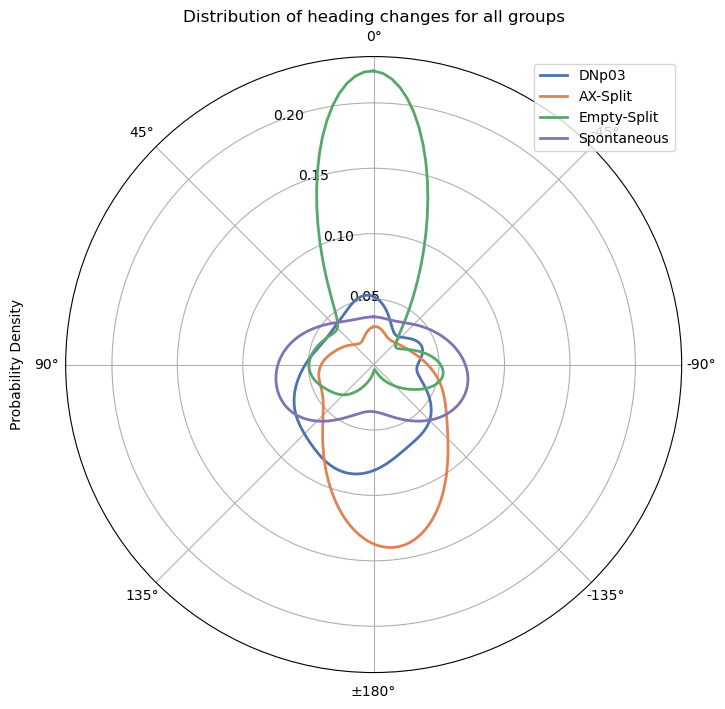

In [ ]:
heading_change_dnp03_stim = np.array(j53_results["heading_changes"])[
    (np.array(j53_results["groups"]) == "stimulus_response")
    | (np.array(j53_results["groups"]) == "stimulus_no_response")
]
heading_change_ax_stim = np.array(ax_split_results["heading_changes"])[
    (np.array(ax_split_results["groups"]) == "stimulus_response")
    | (np.array(ax_split_results["groups"]) == "stimulus_no_response")
]
heading_change_empty_stim = np.array(empty_split_results["heading_changes"])[
    (np.array(empty_split_results["groups"]) == "stimulus_response")
    | (np.array(empty_split_results["groups"]) == "stimulus_no_response")
]
heading_change_spont_combined = np.concatenate(
    [
        np.array(j53_results["heading_changes"])[
            np.array(j53_results["groups"]) == "spontaneous"
        ],
        np.array(ax_split_results["heading_changes"])[
            np.array(ax_split_results["groups"]) == "spontaneous"
        ],
        np.array(empty_split_results["heading_changes"])[
            np.array(empty_split_results["groups"]) == "spontaneous"
        ],
    ]
)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde


# Convert degrees to radians
def to_rad(deg_array):
    return np.deg2rad(deg_array)


# Create figure
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 8))
ax.set_theta_zero_location("N")

# Define colors for better visibility
colors = cp
labels = ["DNp03", "AX-Split", "Empty-Split", "Spontaneous"]

datasets = [
    heading_change_dnp03_stim,
    heading_change_ax_stim,
    heading_change_empty_stim,
    heading_change_spont_combined,
]

for data, color, label in zip(datasets, colors, labels):
    # Convert to radians
    data_rad = data

    # Create evenly spaced points for evaluation
    theta = np.linspace(0, 2 * np.pi, 200)

    # Compute KDE
    # Duplicate some data points across boundaries to ensure continuity
    data_wrapped = np.concatenate(
        [data_rad, data_rad + 2 * np.pi, data_rad - 2 * np.pi]
    )
    kde = gaussian_kde(data_wrapped, bw_method=0.05)  # Adjust bw_method as needed

    # Evaluate KDE
    density = kde(theta)
    # density = density / density.max()  # Normalize

    # Plot
    ax.plot(theta, density, color=color, label=label, lw=2)

# Customize plot
# ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Set radial ticks
ax.grid(True)
ax.legend()
ax.set_thetagrids(
    np.arange(0, 360, 45),
    labels=["0°", "45°", "90°", "135°", "±180°", "-135°", "-90°", "-45°"],
)

plt.title("Distribution of heading changes for all groups")
plt.ylabel("Probability Density", labelpad=30)
plt.savefig(
    f"Figures/dnp03_paper/{date_time}/heading_change_kde_not_normalized.png", dpi=150
)
plt.savefig(
    f"Figures/dnp03_paper/{date_time}/heading_change_kde_not_normalized.svg", dpi=300
)
plt.show()

In [ ]:
dnp03_angvel_stim = np.array(j53_results["angular_velocities"])[
    (np.array(j53_results["groups"]) == "stimulus_response")
]
ax_angvel_stim = np.array(ax_split_results["angular_velocities"])[
    (np.array(ax_split_results["groups"]) == "stimulus_response")
]
empty_angvel_stim = np.array(empty_split_results["angular_velocities"])[
    (np.array(empty_split_results["groups"]) == "stimulus_response")
]
spontaneous_angvel_stim = np.concatenate(
    [
        np.array(j53_results["angular_velocities"])[
            np.array(j53_results["groups"]) == "spontaneous"
        ],
        np.array(ax_split_results["angular_velocities"])[
            np.array(ax_split_results["groups"]) == "spontaneous"
        ],
        np.array(empty_split_results["angular_velocities"])[
            np.array(empty_split_results["groups"]) == "spontaneous"
        ],
    ]
)

import numpy as np
import matplotlib.pyplot as plt


def get_mean_and_sem(arr):
    new_arr = []
    for a in arr:
        a = np.rad2deg(a)
        a = np.abs(a)
        a = a - np.mean(a[:50])
        new_arr.append(a)
    arr = np.array(new_arr)
    mean = np.mean(arr, axis=0)
    sem = np.std(arr, axis=0)  # / np.sqrt(arr.shape[0])  # Standard Error of Mean
    return mean, sem


# Calculate mean and SEM
dnp03_mean, dnp03_sem = get_mean_and_sem(dnp03_angvel_stim)
ax_mean, ax_sem = get_mean_and_sem(ax_angvel_stim)
empty_mean, empty_sem = get_mean_and_sem(empty_angvel_stim)
spont_mean, spont_sem = get_mean_and_sem(spontaneous_angvel_stim)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
time = np.linspace(-100, 100, 200) * 0.01

# Plot experimental conditions in top subplot
for mean, sem, label, color in [
    (dnp03_mean, dnp03_sem, "DNp03", cp[0]),
    (ax_mean, ax_sem, "AX-Split", cp[1]),
    (empty_mean, empty_sem, "Empty-Split", cp[2]),
]:
    ax.plot(time, mean, label=label, color=color, alpha=0.8, lw=2)
    ax.fill_between(time, mean - sem, mean + sem, alpha=0.2, color=color)

# Plot spontaneous in bottom subplot
ax.plot(time, spont_mean, label="Spontaneous", color=cp[3], alpha=0.8, lw=2)
ax.fill_between(
    time, spont_mean - spont_sem, spont_mean + spont_sem, alpha=0.2, color=cp[3]
)

# Customize plots

ax.grid(True, alpha=0.3)
ax.set_ylabel("Angular Velocity (°/s)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False)

# Add vertical line at t=0
# ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

ax.set_xlabel("Time (s)")
ax.set_title("Mean Angular Velocity for Stimulus Response only (STD)")

ax.set_xlim(-0.5, 0.75)
# Adjust layout
plt.tight_layout()
plt.savefig(f"Figures/dnp03_paper/{date_time}/angular_velocity_mean_std.png", dpi=150)
plt.savefig(f"Figures/dnp03_paper/{date_time}/angular_velocity_mean_std.svg", dpi=300)

### Methods

In [225]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

i = 0
obj_id = j53_data["stim"]["obj_id"].iloc[i]
frame = j53_data["stim"]["frame"].iloc[i]
exp_num = j53_data["stim"]["exp_num"].iloc[i]

grp = j53_data["df"][
    (j53_data["df"]["obj_id"] == obj_id) & (j53_data["df"]["exp_num"] == exp_num)
].copy()

stim_idx = np.where(grp["frame"] == frame)[0][0]

# Smooth data
grp = sg_smooth(grp)

# Calculate angular and linear velocity
xvel, yvel = grp["xvel"].to_numpy(), grp["yvel"].to_numpy()
x, y, z = grp["x"].to_numpy(), grp["y"].to_numpy(), grp["z"].to_numpy()

# Calculate angular and linear velocity
theta = np.arctan2(yvel, xvel)
theta_unwrap = np.unwrap(theta)
_, angular_velocity = pynumdiff.smooth_finite_difference.butterdiff(
    theta_unwrap, dt=0.01, params=[1, 0.1]
)
linear_velocity = np.sqrt(xvel**2 + yvel**2)

saccades, _ = scipy.signal.find_peaks(
    np.abs(angular_velocity),
    height=np.deg2rad(300),
    distance=10,
    prominence=5,
)

# find saccade immediatly after stim_idx
stim_saccade_idx = np.where((saccades > stim_idx) & (saccades < stim_idx + 30))[0][0]
stim_saccade = saccades[stim_saccade_idx]
saccades = np.delete(saccades, stim_saccade_idx)


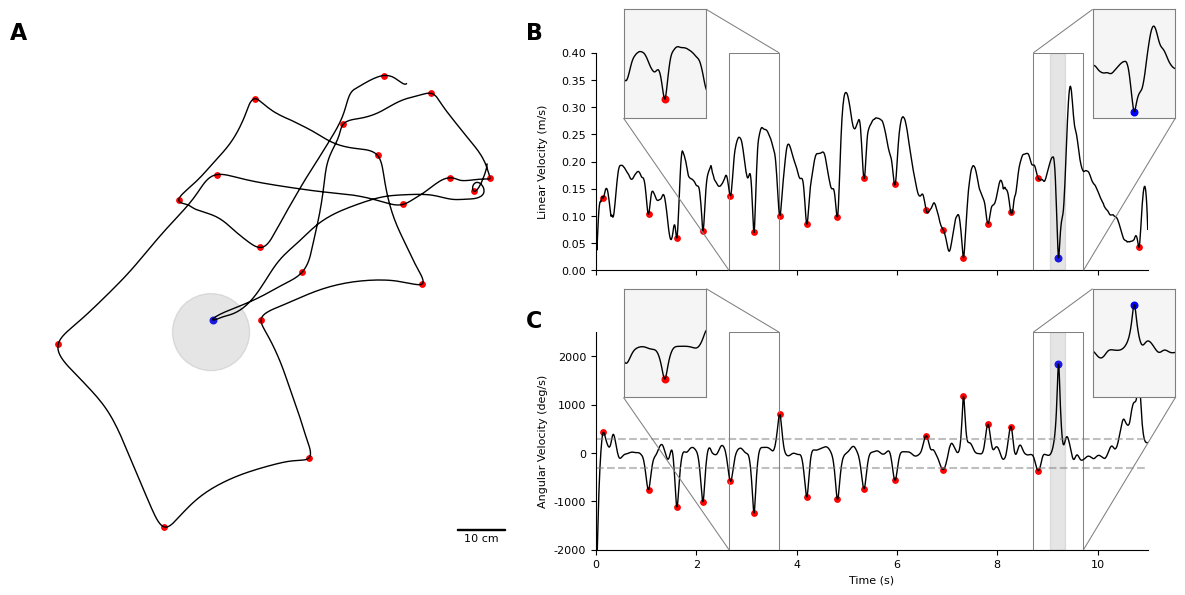

In [296]:
def create_velocity_inset(
    parent_ax,
    x_pos,
    time_data,
    velocity_data,
    saccade_idx,
    color,
    y_limits,
    window=50,
    connect_pos=(1, 2),
):
    """Create an inset with consistent formatting"""
    inset = parent_ax.inset_axes([x_pos, 0.7, 0.15, 0.5])  # Made insets larger
    inset.plot(time_data, velocity_data, color="black", lw=1)
    inset.scatter(
        time_data[saccade_idx],
        velocity_data[saccade_idx],
        s=sz * 1.5,
        marker="o",
        color=color,
    )

    left_idx = max(0, saccade_idx - window)
    right_idx = min(len(time_data), saccade_idx + window)
    inset.set_xlim(time_data[left_idx], time_data[right_idx])
    inset.set_ylim(y_limits)

    # Add light gray background
    inset.set_facecolor("whitesmoke")

    mark_inset(
        parent_ax,
        inset,
        loc1=connect_pos[0],
        loc2=connect_pos[1],
        fc="none",
        ec="0.5",
        lw=0.75,
    )
    inset.set_xticks([])
    inset.set_yticks([])

    inset.spines["top"].set_visible(True)
    inset.spines["right"].set_visible(True)
    inset.spines["bottom"].set_visible(True)
    inset.spines["left"].set_visible(True)
    inset.spines["top"].set_color("gray")
    inset.spines["right"].set_color("gray")
    inset.spines["bottom"].set_color("gray")
    inset.spines["left"].set_color("gray")

    return inset

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Create figure
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

sz = 15
X_time = np.linspace(0, len(x) * 0.01, len(x))

## Plot 1: Trajectory
ax1.plot(x, y, color="black", lw=1)
ax1.scatter(x[saccades], y[saccades], s=sz, marker="o", color="red")
ax1.scatter(x[stim_saccade], y[stim_saccade], s=sz * 1.5, marker="o", color="blue")

# Improved arena visualization
opto_circle = plt.Circle((0, 0), 0.025, color="gray", alpha=0.2)
ax1.add_artist(opto_circle)

# Add scale bar
scalebar = AnchoredSizeBar(
    ax1.transAxes,
    0.1,  # Length in axis units (in this case, 10 cm = 0.1 m)
    '10 cm',
    'lower right',
    pad=0.5,
    color='black',  # Changed from white to black
    frameon=False,
    size_vertical=0.003,  # Make the bar thicker
    fontproperties=fm.FontProperties(size=8)  # Adjust font size if needed
)
ax1.add_artist(scalebar)
ax1.spines["bottom"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_aspect("equal")

## Plot 2: Linear Velocity
ax2.plot(X_time, linear_velocity, color="black", lw=1)
ax2.scatter(X_time[saccades], linear_velocity[saccades], s=sz, marker="o", color="red")
ax2.scatter(
    X_time[stim_saccade],
    linear_velocity[stim_saccade],
    s=sz * 1.5,
    marker="o",
    color="blue",
)
ax2.axvspan(X_time[stim_idx], X_time[stim_idx] + 0.3, color="gray", alpha=0.2)

# Create insets with same y-limits for better comparison
linear_vel_ylim = (0.0, 0.4)
random_saccade = saccades[5]
create_velocity_inset(
    ax2,
    0.05,
    X_time,
    linear_velocity,
    random_saccade,
    "red",
    linear_vel_ylim,
    connect_pos=(1, 3),
)
create_velocity_inset(
    ax2,
    0.9,
    X_time,
    linear_velocity,
    stim_saccade,
    "blue",
    linear_vel_ylim,
    connect_pos=(2, 4),
)

## Plot 3: Angular velocity
ax3.plot(X_time, angular_velocity, color="black", lw=1)
ax3.scatter(X_time[saccades], angular_velocity[saccades], s=sz, marker="o", color="red")
ax3.scatter(
    X_time[stim_saccade],
    angular_velocity[stim_saccade],
    s=sz * 1.5,
    marker="o",
    color="blue",
)
ax3.axvspan(X_time[stim_idx], X_time[stim_idx] + 0.3, color="gray", alpha=0.2)

# Create insets with same y-limits for better comparison
angular_vel_ylim = (np.deg2rad(-2000), np.deg2rad(2500))
create_velocity_inset(
    ax3,
    0.05,
    X_time,
    angular_velocity,
    random_saccade,
    "red",
    angular_vel_ylim,
    connect_pos=(1, 3),
)
create_velocity_inset(
    ax3,
    0.9,
    X_time,
    angular_velocity,
    stim_saccade,
    "blue",
    angular_vel_ylim,
    connect_pos=(2, 4),
)

# Formatting improvements
for ax in [ax1, ax2, ax3]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Y-axis formatting for angular velocity
yticks = np.arange(-2000, 2001, 1000)
ax3.set_yticks(np.deg2rad(yticks))
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{np.rad2deg(x):.0f}"))

# Labels and limits
#ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Linear Velocity (m/s)")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Angular Velocity (deg/s)")

ax2.set_ylim(0.0, 0.4)
ax3.set_ylim(np.deg2rad(-2000), np.deg2rad(2500))
ax2.set_xlim(0, max(X_time))
ax3.set_xlim(0, max(X_time))

#ax3.tick_params
ax2.set_xticklabels([])

ax3.axhline(y = np.deg2rad(300), color='gray', linestyle='--', alpha=0.5)
ax3.axhline(y = -np.deg2rad(300), color='gray', linestyle='--', alpha=0.5)

# Add annotations
fig.text(0.02, 0.96, 'A', fontsize=16, fontweight='bold', va='top')
fig.text(0.45, 0.96, 'B', fontsize=16, fontweight='bold', va='top')
fig.text(0.45, 0.96/2, 'C', fontsize=16, fontweight='bold', va='top')

# If you need to adjust the layout to make room for the labels
plt.tight_layout(rect=[0.03, 0, 1, 1])  # Left margin slightly larger to accommodate labels

plt.tight_layout()
plt.rcParams['font.size'] = 8.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica', 'sans-serif']

# Optional: If you want to ensure text is exported properly in PDFs
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig.align_ylabels([ax2, ax3])
plt.savefig(f"Figures/dnp03_paper/{date_time}/saccade_analysis_example.png", dpi=150)
plt.savefig(f"Figures/dnp03_paper/{date_time}/saccade_analysis_example.svg", dpi=300)
plt.show()